# EDA and Modeling

This notebook will focus on exploring our lyrics dataset and creating our model for our lyrics classifier. Analysis on model performance and expectations will be present throughout.

In [1]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import time
import itertools
import nltk
import string
import ast 
import gensim
import plotly
import plotly.graph_objs as go
%matplotlib inline


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.ensemble import BaggingClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk import pos_tag
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.stem import PorterStemmer
from pprint import pprint
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.naive_bayes import MultinomialNB
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file
from sklearn.manifold import TSNE

Word2Vec-Keras Text Classifier can complete text classification without feature engineering.it combines the Word2Vec Gensim model woth Keras.

In [3]:
lyrics_df = pd.read_csv('C:/Users/Fib0nacci/Desktop/Assignments/Capstone/Data/clean_lyrics.csv', index_col=False) #Reading in the cleaned lyrics dataset


In [4]:
lyrics_df = lyrics_df.drop(['Unnamed: 0'], axis= 1) #Dropping unnamed column.

In [229]:
#Tokenizing our lyrics_cleaned column
def tokenize(txt):
    token = re.split('\W+', txt)
    return token

In [230]:
lyrics_df['lyrics_cleaned'] = lyrics_df['lyrics_cleaned'].apply(lambda x: tokenize(x))

<Figure size 1152x576 with 0 Axes>

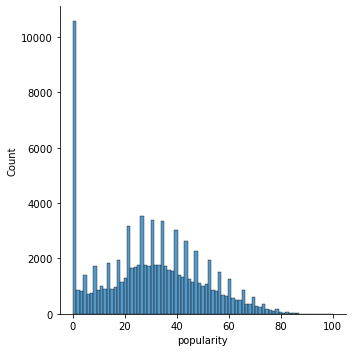

In [23]:
# Plotting the distribution of popularity
plt.figure(figsize=(16,8))
sns.displot(lyrics_df['popularity'])
plt.show()

We see that there are a lot of songs with a popularity score of 0. this is a clear outlier from the plot above. We also see that majority of our songs lie within a popularity range from 20 to 50.

## Sentiment Analysis EDA

I want to look at the positive, negative and neutral words that affect each genre. I will create a dataframe that holds the sentiment scores.

In [231]:
sa = SentimentIntensityAnalyzer()

In [232]:
#passing my column through sentiment analysis.
lyrics_df['sentiment'] = lyrics_df['lyrics'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

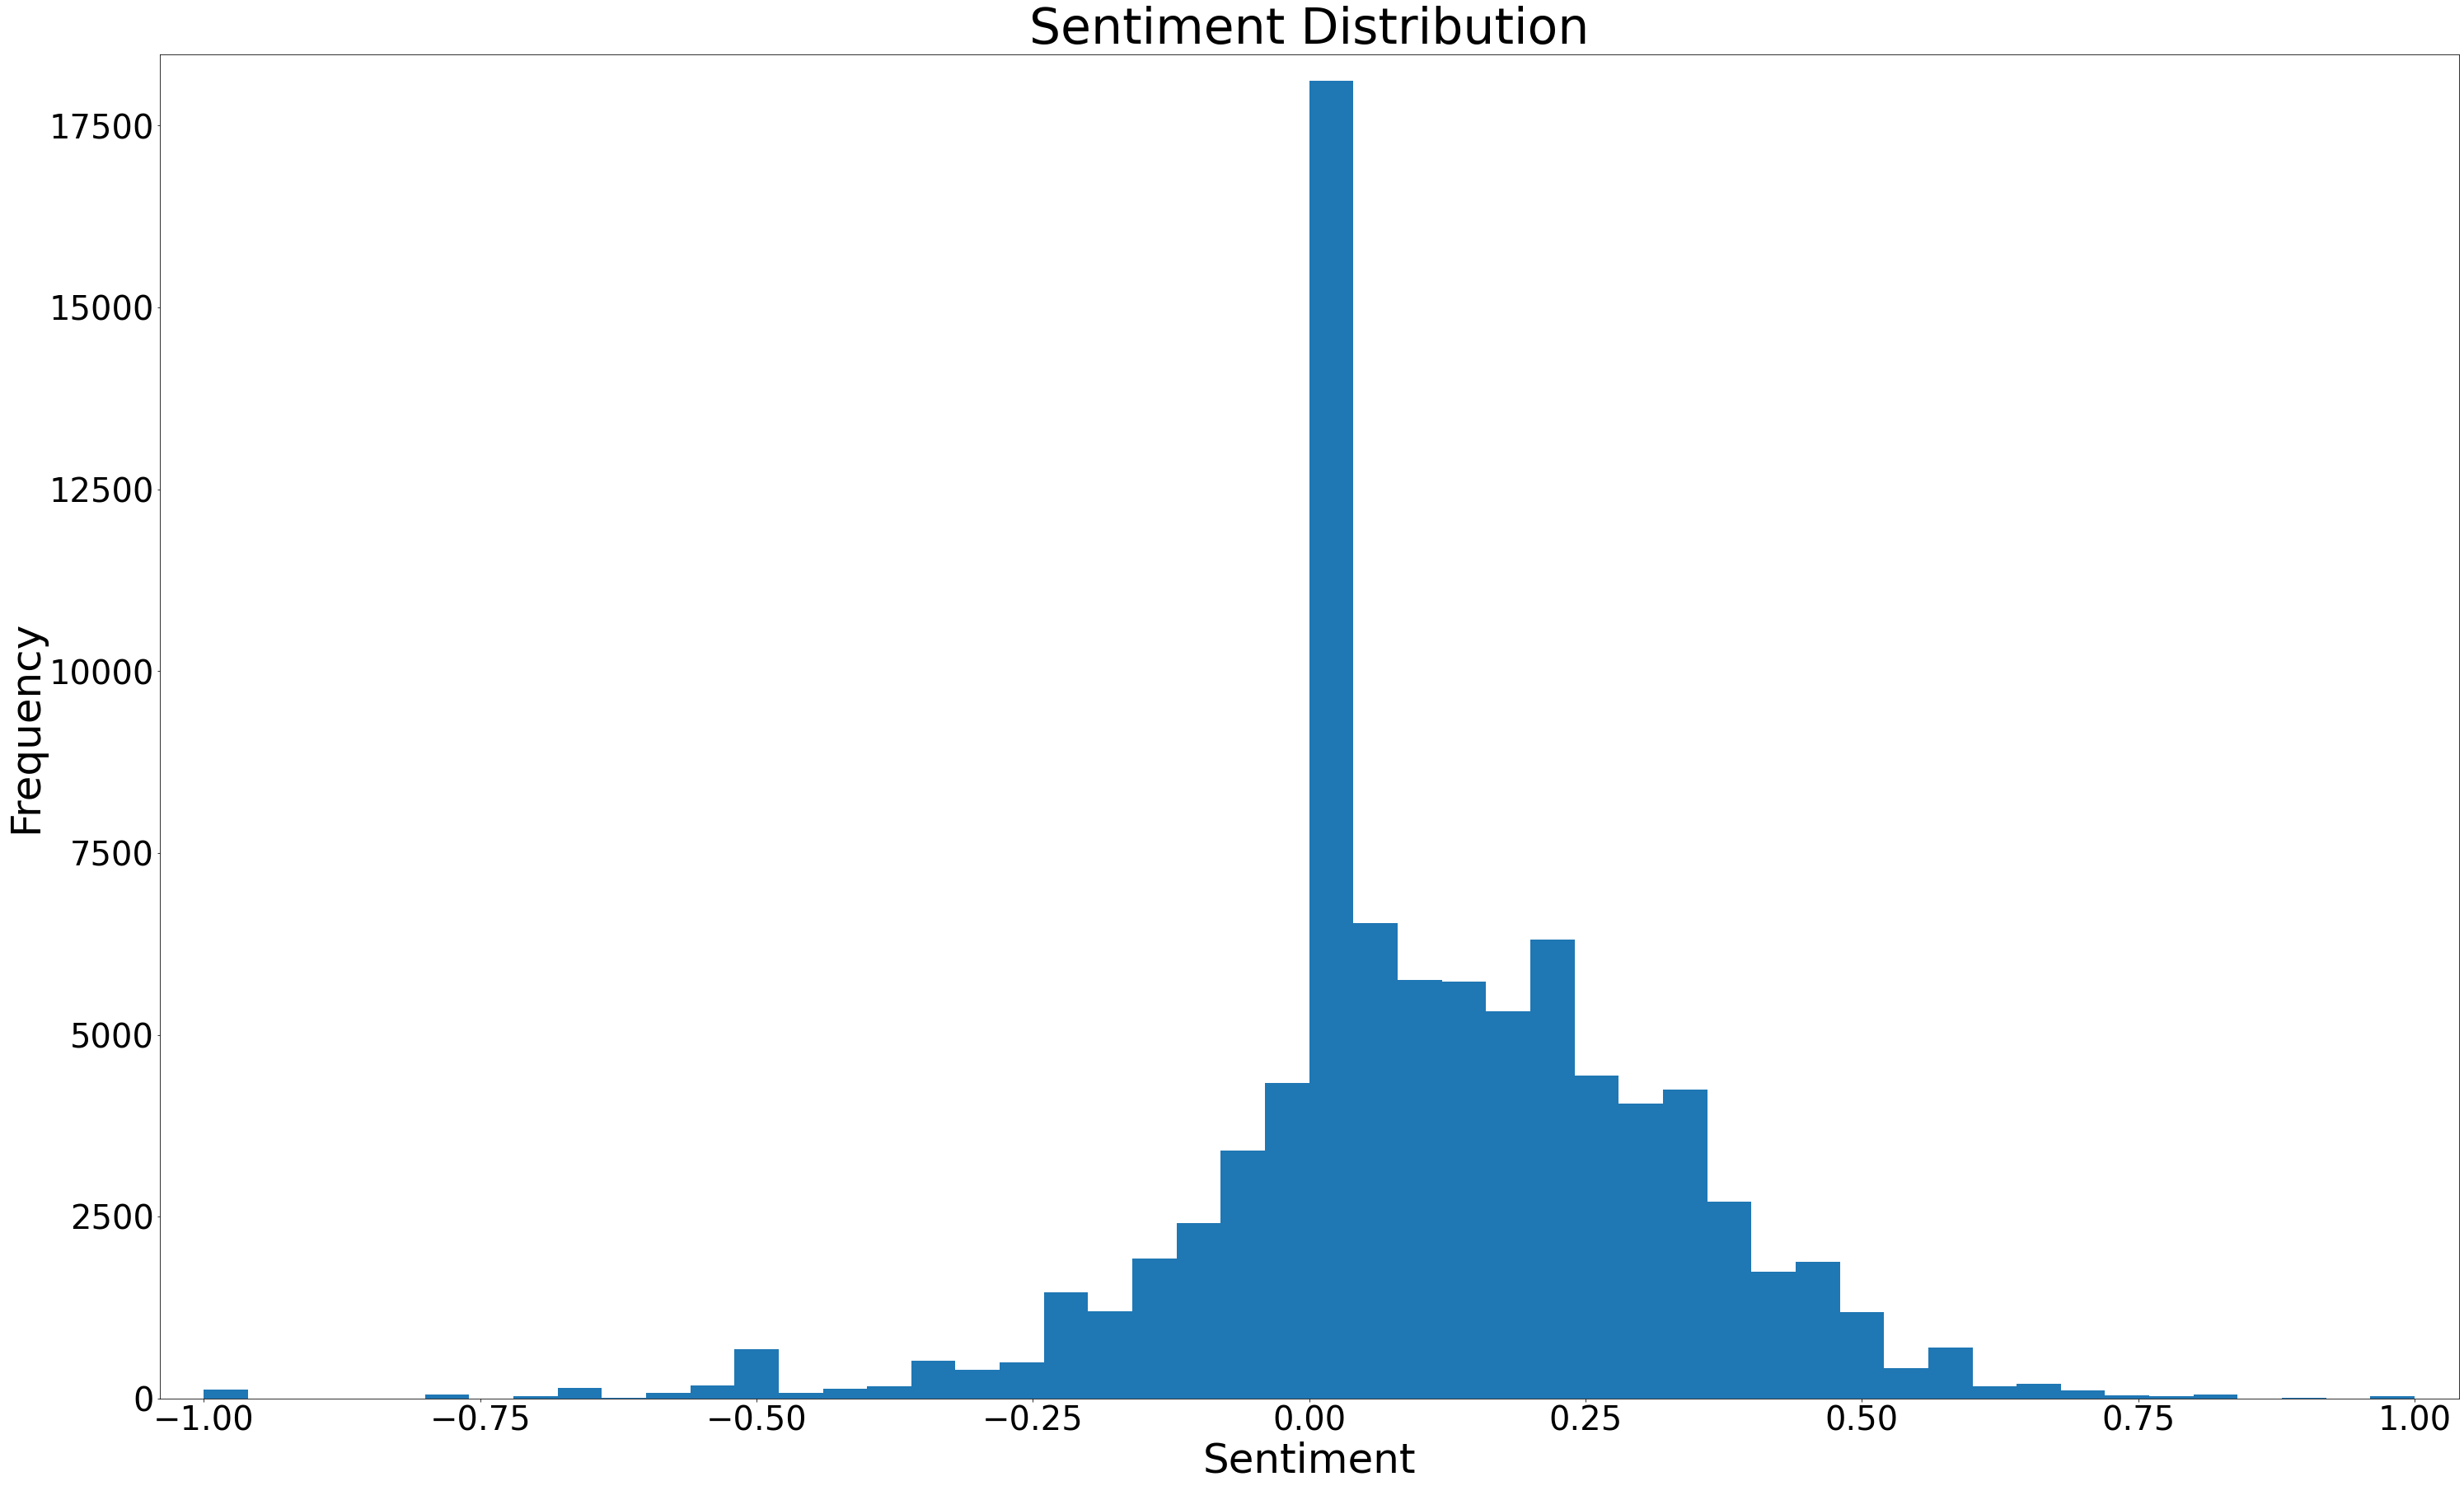

In [33]:
#Code adapted from https://towardsdatascience.com/nlp
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(lyrics_df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

The overall sentiment among genres is normally distributed outside of the 0 value outlier

In [242]:
#Plotting sentiments by genre
sentiments = lyrics_df.groupby('genres')['sentiment']

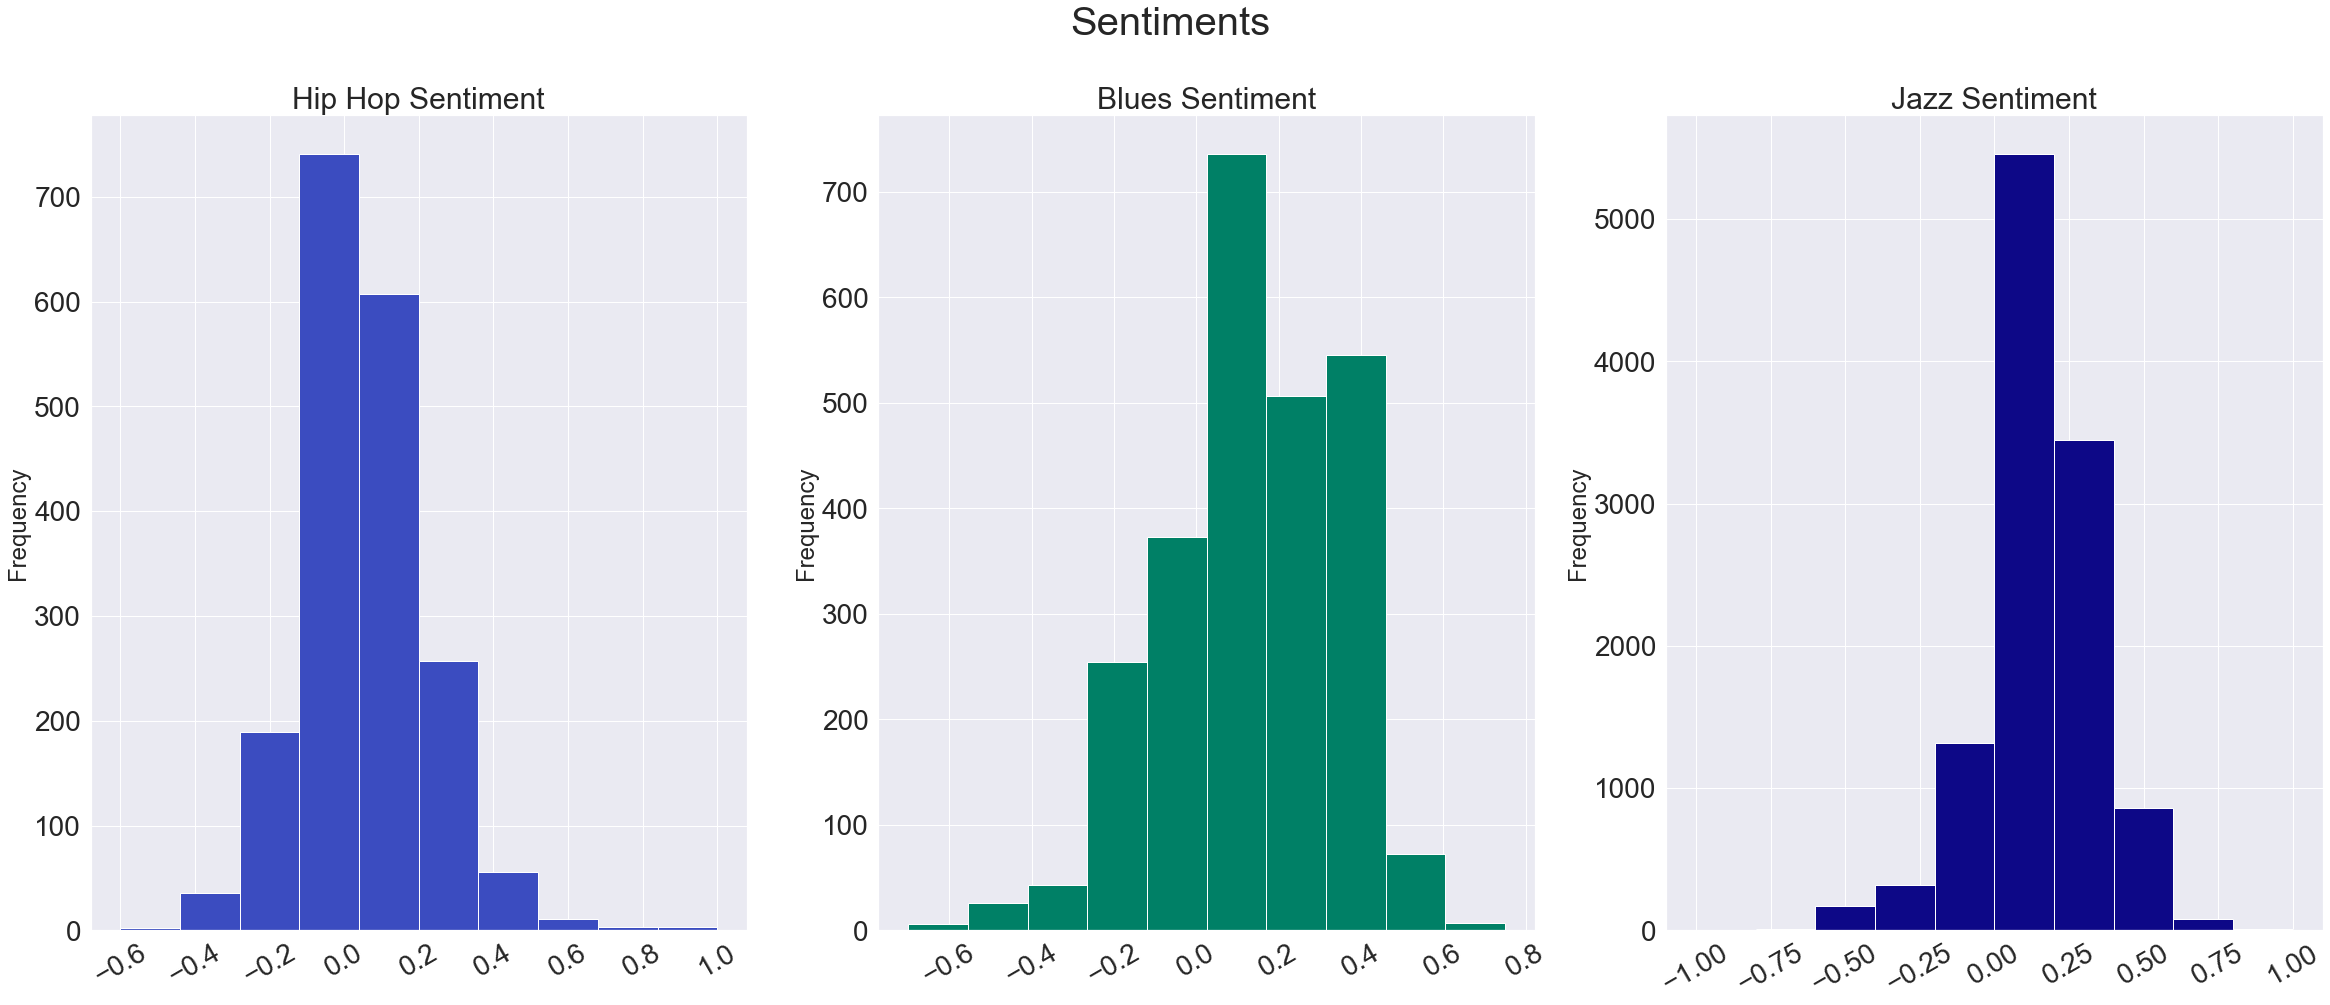

In [251]:
fig, axes = plt.subplots(1, 3, figsize=(40, 15), sharey=False)
fig.suptitle('Sentiments', size=40)

sentiments.get_group('hip hop').plot.hist(ax=axes[0], xlabel='sentiment', ylabel='Frequency', cmap='coolwarm', rot=30, fontsize=28 )
axes[0].set_title('Hip Hop Sentiment', size=30)

sentiments.get_group('blues').plot.hist(ax=axes[1], xlabel='sentiment', ylabel='Frequency', cmap='summer', rot=30, fontsize=28 )
axes[1].set_title('Blues Sentiment', size=30)

sentiments.get_group('jazz').plot.hist(ax=axes[2], xlabel='sentiment', ylabel='Frequency', cmap='plasma', rot=30, fontsize=28 )
axes[2].set_title('Jazz Sentiment', size=30)

sns.set(font_scale = 2)


Text(0.5, 1.0, 'Other Sentiment')

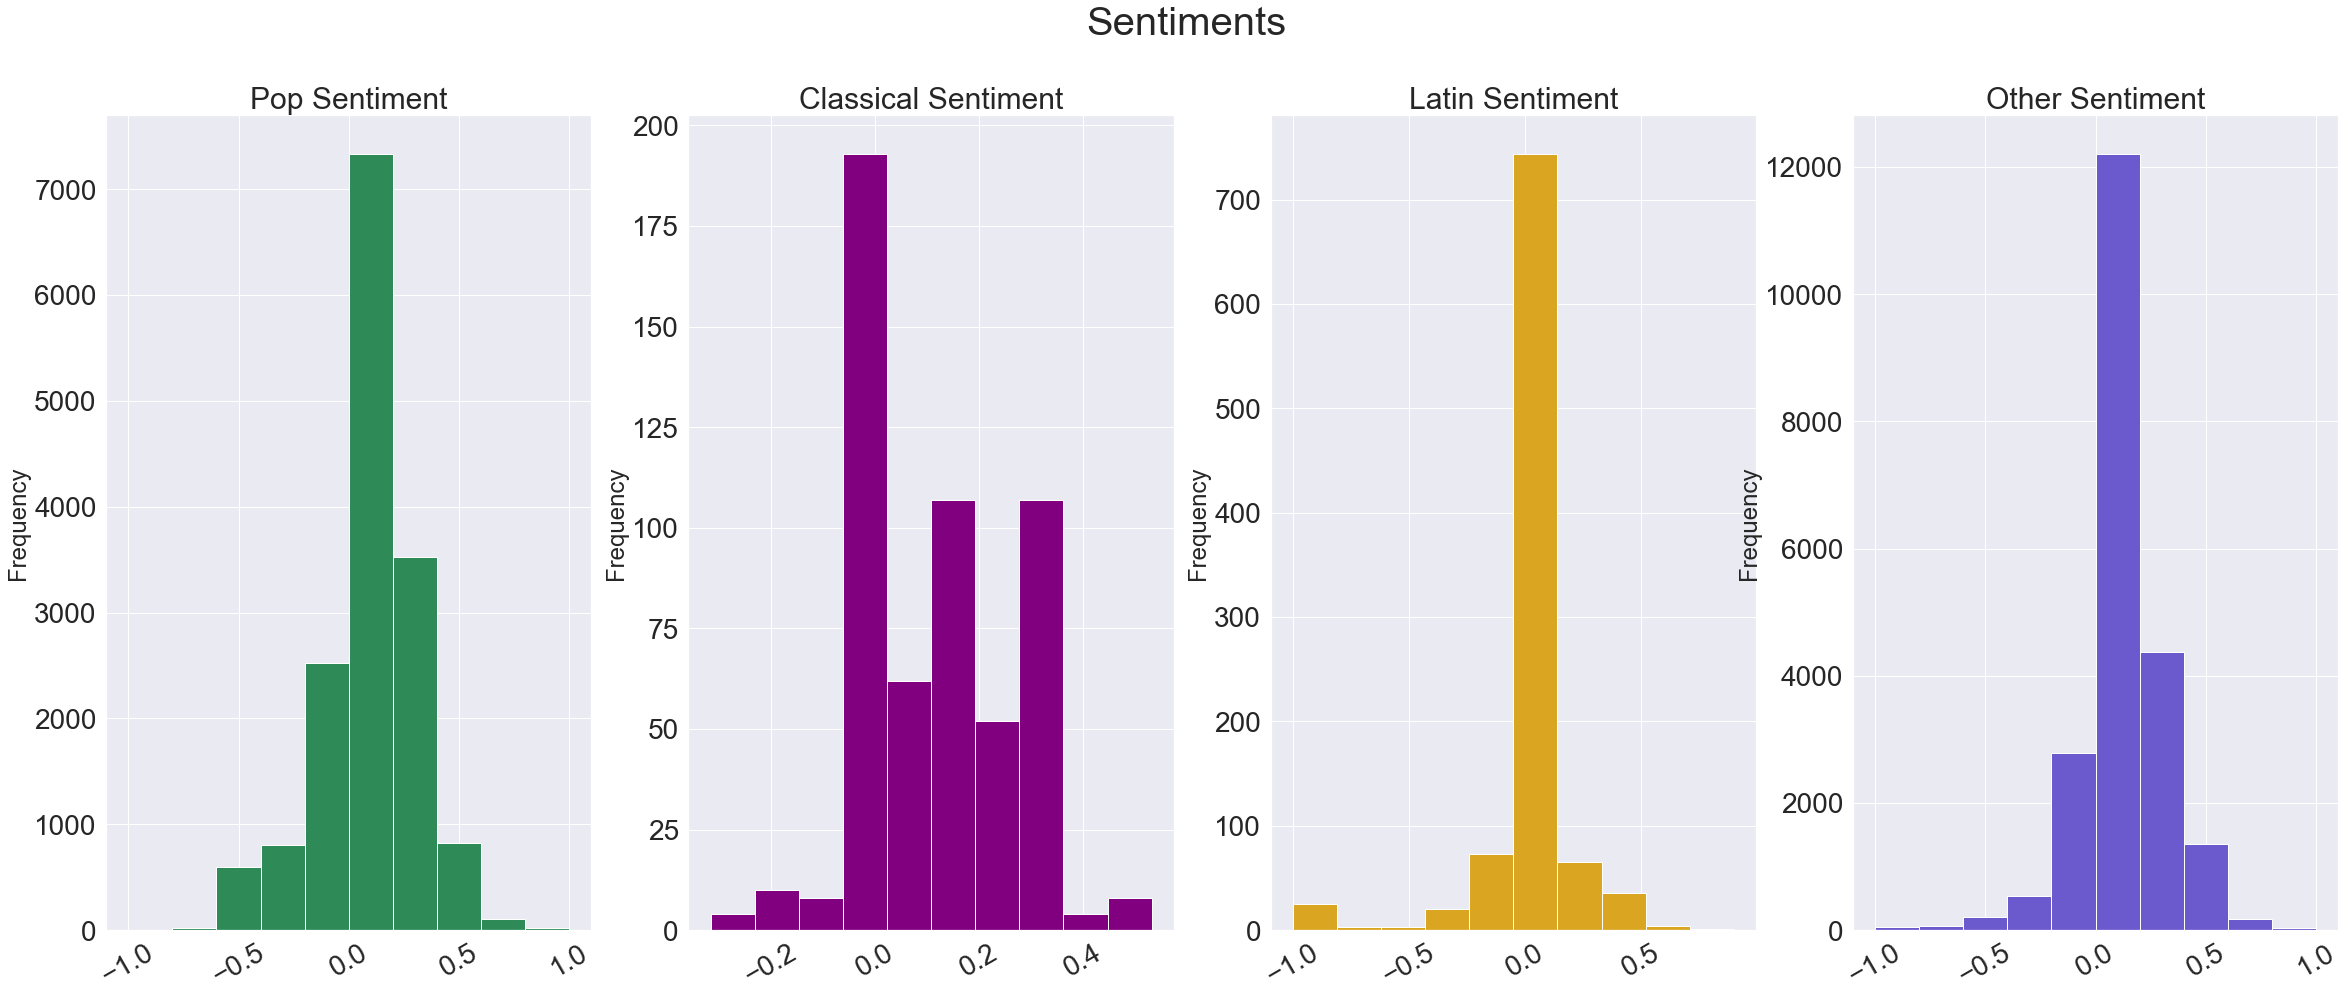

In [254]:
fig, axes = plt.subplots(1, 4, figsize=(40, 15), sharey=False)
fig.suptitle('Sentiments', size=40)

sentiments.get_group('pop').plot.hist(ax=axes[0], xlabel='sentiment', ylabel='Frequency', color='seagreen', rot=30, fontsize=28 )
axes[0].set_title('Pop Sentiment', size=30)

sentiments.get_group('classical').plot.hist(ax=axes[1], xlabel='sentiment', ylabel='Frequency', color='purple', rot=30, fontsize=28 )
axes[1].set_title('Classical Sentiment', size=30)

sentiments.get_group('latin').plot.hist(ax=axes[2], xlabel='sentiment', ylabel='Frequency', color='goldenrod', rot=30, fontsize=28 )
axes[2].set_title('Latin Sentiment', size=30)

sentiments.get_group('other').plot.hist(ax=axes[3], xlabel='sentiment', ylabel='Frequency', color='slateblue', rot=30, fontsize=28 )
axes[3].set_title('Other Sentiment', size=30)

#sns.set(font_scale = 2)


Text(0.5, 1.0, 'Rock Sentiment')

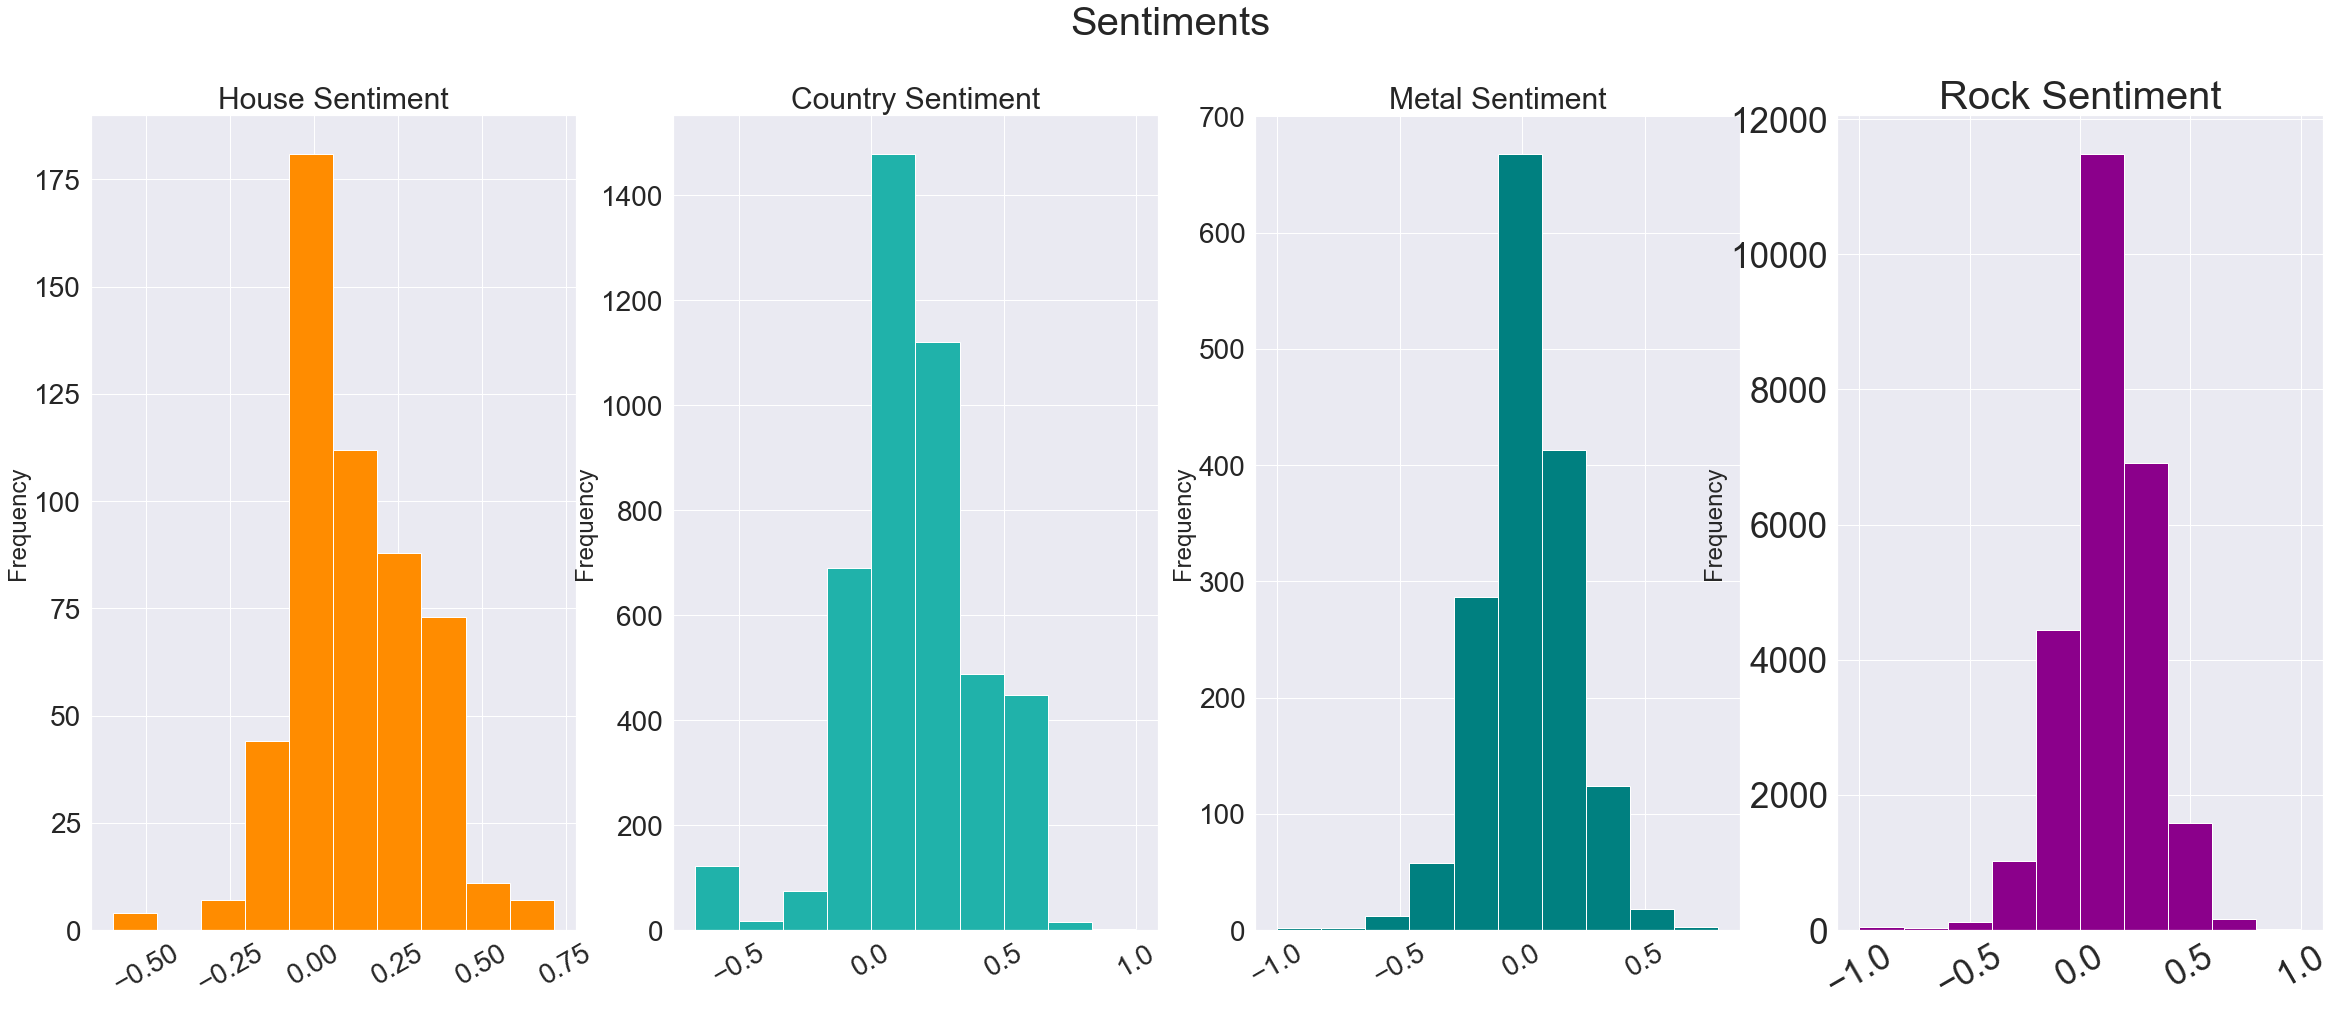

In [253]:
fig, axes = plt.subplots(1, 4, figsize=(40, 15), sharey=False)
fig.suptitle('Sentiments', size=40)

sentiments.get_group('house').plot.hist(ax=axes[0], xlabel='sentiment', ylabel='Frequency', color='darkorange', rot=30, fontsize=28 )
axes[0].set_title('House Sentiment', size=30)

sentiments.get_group('country').plot.hist(ax=axes[1], xlabel='sentiment', ylabel='Frequency', color='lightseagreen', rot=30, fontsize=28 )
axes[1].set_title('Country Sentiment', size=30)

sentiments.get_group('metal').plot.hist(ax=axes[2], xlabel='sentiment', ylabel='Frequency', color='teal', rot=30, fontsize=28 )
axes[2].set_title('Metal Sentiment', size=30)

sentiments.get_group('rock').plot.hist(ax=axes[3], xlabel='sentiment', ylabel='Frequency', color='darkmagenta', rot=30,  fontsize=35 )
axes[3].set_title('Rock Sentiment', size=40)


#sns.set(font_scale = 2)


## Sentiment Analysis Conclusions
All of the genres have a high value of neutrality at 0. Blues and pop music have higher values of negative sentiment within their spread than other genres. Hip hop is next in line in terms of negative sentiment values. The other category- which consists of niche genres- also has a high neutrality of 0. Generally, all of our genres are positive trending. If the 0 outlier was removed, we would see a normal distribution shape for most of the genres. Classical music however, would not follow the normal distribution plot.

## Word Count EDA 

Now I will view the word counts among certain genres. I will look at word count for hip hop, blues, and metal. I want to see if there's a difference among the count for our genres. I will also compare and contrast the mean 'popularity' scores  with the word count to see if there is any obvious correlation.

In [18]:
blues = lyrics_df[lyrics_df['genres'].str.contains('blues')]
blues['word_count'] = blues['lyrics'].apply(lambda x: len(str(x).split()))
#display(blues.head(20))
display(blues['word_count'].mean()) #the average word count for the 'blues' genre is roughly 99 words
print(f'The average popularity for blues is:', '', {blues['popularity'].mean()})

<ipython-input-18-1ff39116cba4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blues['word_count'] = blues['lyrics'].apply(lambda x: len(str(x).split()))


98.96417445482867

The average popularity for blues is:  {20.222741433021806}


In [23]:
hip_hop = lyrics_df[lyrics_df['genres'].str.contains('hip hop')]
hip_hop['word_count'] = hip_hop['lyrics'].apply(lambda x: len(str(x).split()))
#display(hip_hop.head(20))
display(hip_hop['word_count'].mean())
print(f'The average popularity for hip hop is:', '', {hip_hop['popularity'].mean()})

<ipython-input-23-5c4870a5e917>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hip_hop['word_count'] = hip_hop['lyrics'].apply(lambda x: len(str(x).split()))


247.71286089238845

The average popularity for hip hop is:  {48.47664041994751}


The average word count for the 'hip hop' genre is roughly 248 words! Many more than 'blues' genre.

In [24]:
metal = lyrics_df[lyrics_df['genres'].str.contains('metal')]
metal['word_count'] = metal['lyrics'].apply(lambda x: len(str(x).split()))
#display(metal.head())
display(metal['word_count'].mean())
print(f'The average popularity for metal is:', '', {metal['popularity'].mean()})

<ipython-input-24-70710e76445d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal['word_count'] = metal['lyrics'].apply(lambda x: len(str(x).split()))


121.37051039697542

The average popularity for metal is:  {45.06553245116572}


In [180]:
latin = lyrics_df[lyrics_df['genres'].str.contains('latin')]
latin['word_count'] = latin['lyrics'].apply(lambda x: len(str(x).split()))
#display(metal.head())
display(latin['word_count'].mean())
print(f'The average popularity for metal is:', '', {latin['popularity'].mean()})

<ipython-input-180-f2f343fbfbc5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



213.49281314168377

The average popularity for metal is:  {45.79876796714579}


Metal has roughly 121 words which is less than hip hop but more than blues. 

What does this mean? Well, from viewing the average word count and the average popularity, we can assume that the more popular a genre is, the more words there are in that genre.

Lets look at the top word counts for each genre.

In [25]:
#This function helps with streamlining the creation of a genre dataframe from our larger dataset.
#this will help in our plotting of word count/frequency.
def genre_capture(genre):
    gen = lyrics_df[lyrics_df['genres'].str.contains(genre)]
    return gen

In [26]:
genre_capture('pop').head(3) #Testing our function.

,artists,name,popularity,lyrics,lyrics_cleaned,genres,sentiment
13,ST,Comme à l'époque,0,alright alright quite alright money right yeah...,"[, alright, alright, quite, alright, money, ri...",pop,-0.159456
89,THE GUY,When We Die,0,demigod new generation call neo poison matrix ...,"[, demigod, new, generation, call, neo, poison...",pop,0.096879
99,THE GUY,Love for Guns,0,demigod new generation call neo poison matrix ...,"[, demigod, new, generation, call, neo, poison...",pop,0.096879


In [27]:
#Applying our function, excluding the first 3, as those were already created.

h = hip_hop['lyrics'].str.split(expand=True).stack().value_counts()
b = blues['lyrics'].str.split(expand=True).stack().value_counts()
m = metal['lyrics'].str.split(expand=True).stack().value_counts()
p = genre_capture('pop')['lyrics'].str.split(expand=True).stack().value_counts()
j = genre_capture('jazz')['lyrics'].str.split(expand=True).stack().value_counts()
house = genre_capture('house')['lyrics'].str.split(expand=True).stack().value_counts()
c = genre_capture('country')['lyrics'].str.split(expand=True).stack().value_counts()
classic = genre_capture('classical')['lyrics'].str.split(expand=True).stack().value_counts()
l = genre_capture('latin')['lyrics'].str.split(expand=True).stack().value_counts()
r = genre_capture('rock')['lyrics'].str.split(expand=True).stack().value_counts()

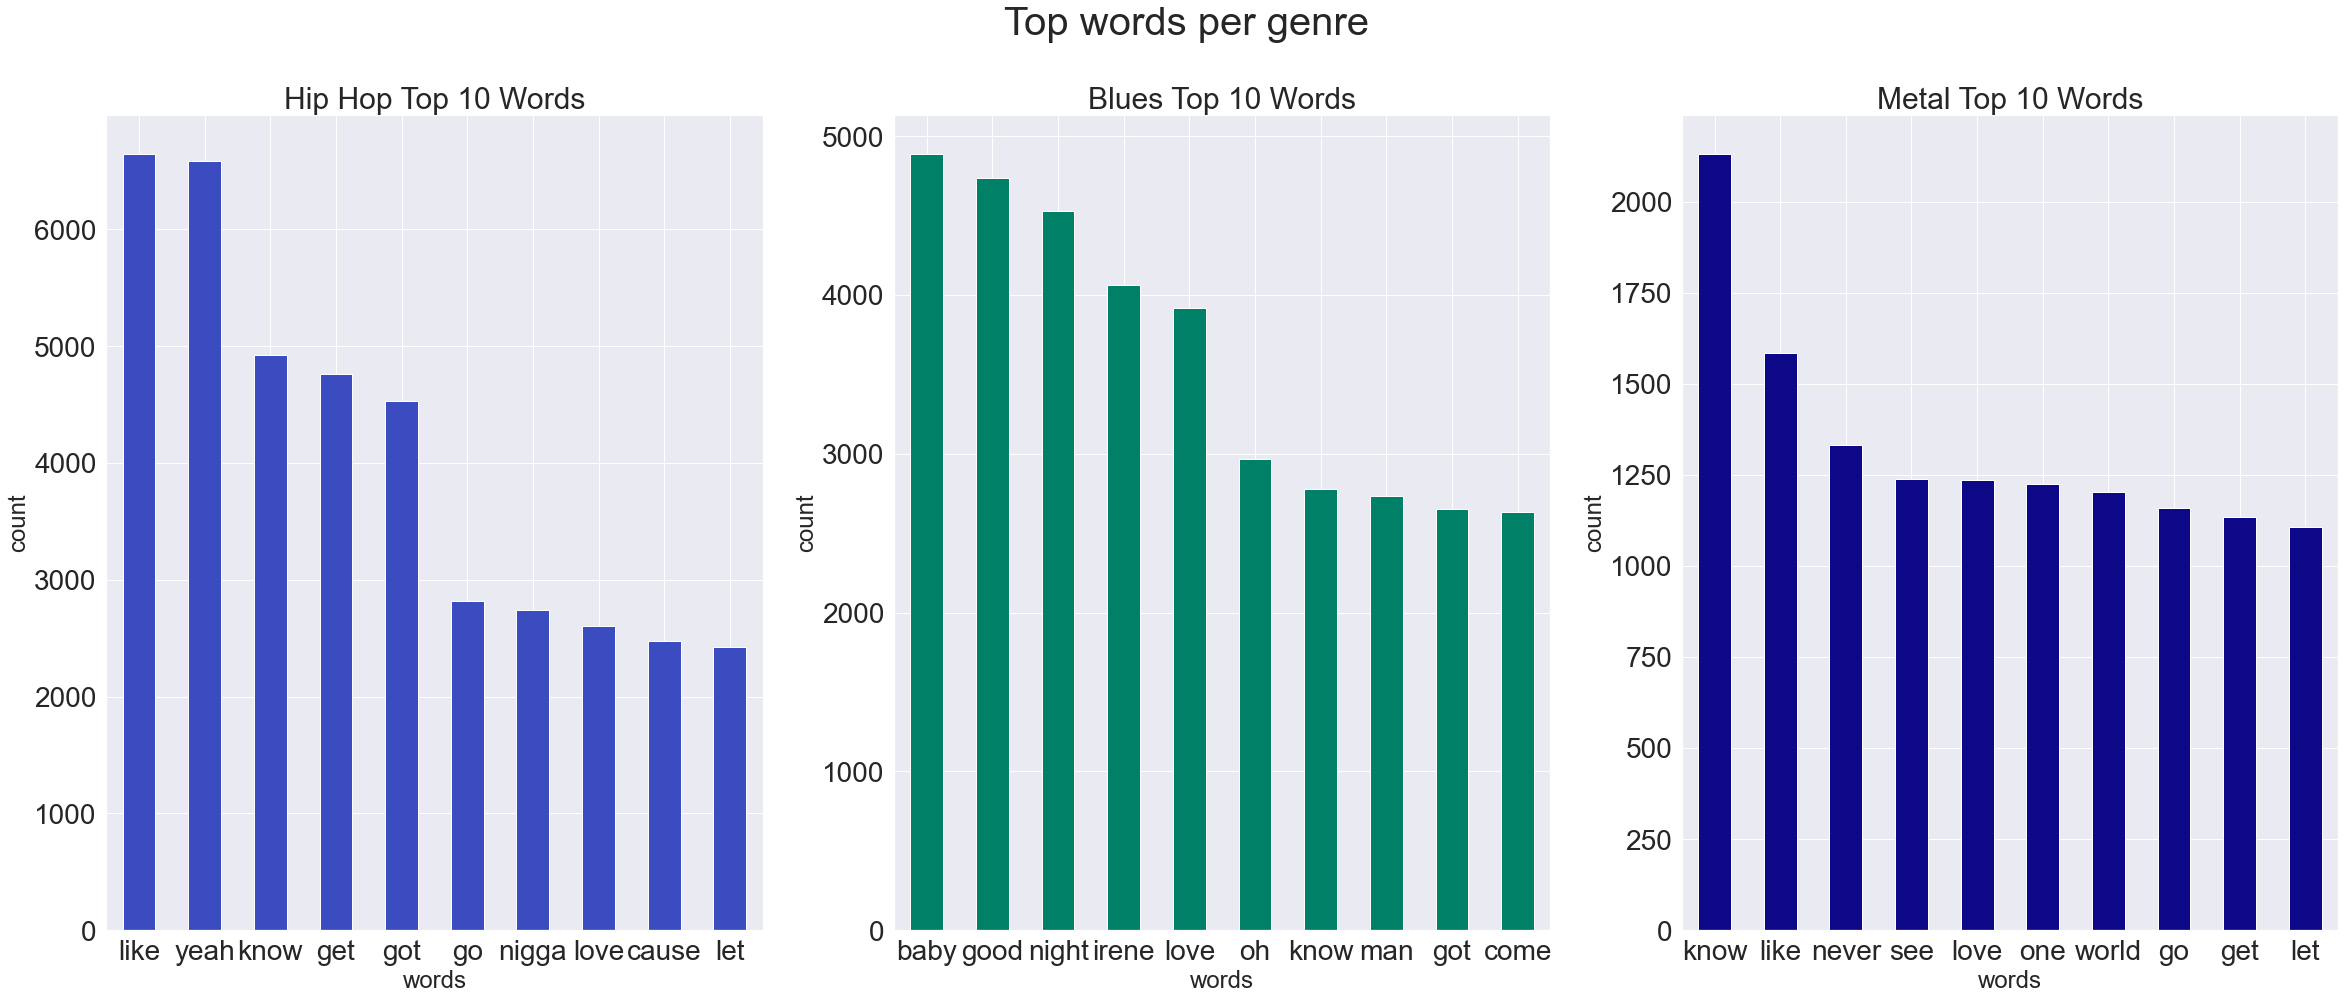

In [29]:
#Top 10 for blues, hip hop and metal genres

fig, axes = plt.subplots(1, 3, figsize=(40, 15), sharey=False)
fig.suptitle('Top words per genre', size=40)

h.head(10).plot.bar(ax=axes[0], xlabel='words', ylabel='count', cmap='coolwarm', rot=0, fontsize=28 )
axes[0].set_title('Hip Hop Top 10 Words', size=30)

b.head(10).plot.bar(xlabel='words', ylabel='count', cmap='summer', rot=0, ax=axes[1], fontsize=28 )
axes[1].set_title('Blues Top 10 Words', size=30)

m.head(10).plot.bar(xlabel='words', ylabel='count', cmap='plasma', rot=0, ax=axes[2], fontsize=28 )
axes[2].set_title('Metal Top 10 Words', size=30)

sns.set(font_scale = 2)


From above we see that metal has a low word frequency count. We also see that hip hop has a higher word count of explicit words in comparison to other genres. Blues has a high freqency of the word 'baby' which makes sense, as blues often sings about sadness and love. It is important to note that some of these words might have overlap due to the method of genre classification used.

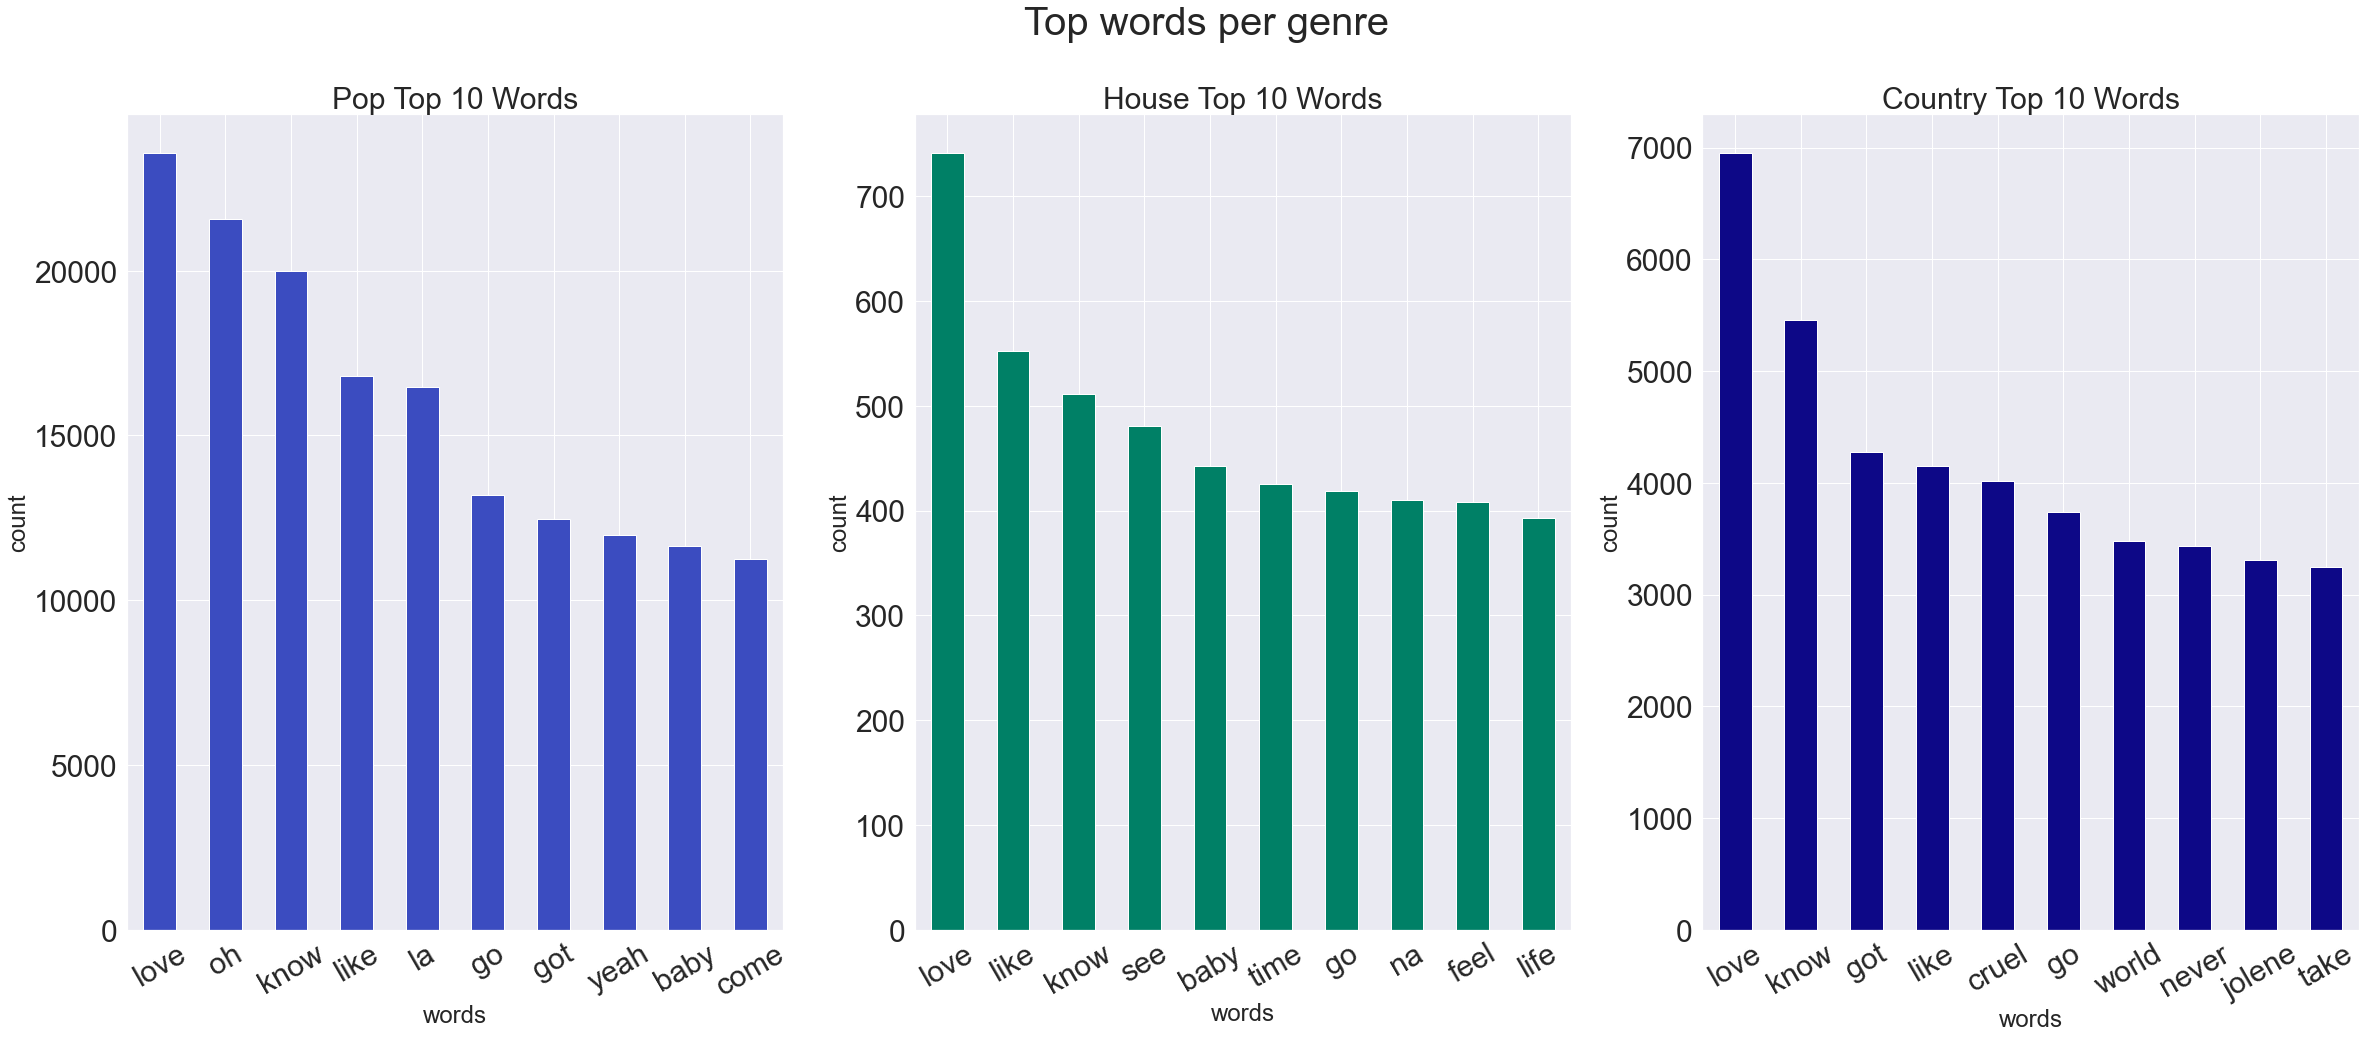

In [30]:
#Top 10 for pop, house and country genres
fig, axes = plt.subplots(1, 3, figsize=(40, 15), sharey=False) # TODO: change Share-y to False
fig.suptitle('Top words per genre', size=40)

p.head(10).plot.bar(ax=axes[0], xlabel='words', ylabel='count', cmap='coolwarm', rot=30, fontsize=30 )
axes[0].set_title('Pop Top 10 Words', size=30)

house.head(10).plot.bar(xlabel='words', ylabel='count', cmap='summer', rot=30, ax=axes[1], fontsize=30 )
axes[1].set_title('House Top 10 Words', size=30)

c.head(10).plot.bar(xlabel='words', ylabel='count', cmap='plasma', rot=30, ax=axes[2], fontsize=30 )
axes[2].set_title('Country Top 10 Words', size=30)

sns.set(font_scale = 2)

From the above plot, we see that house music has a very low use of words. Pop has a high use of words. This makes sense, considering pop music has a high popularity score, and high scores are correlated with high word count/frequency. There is a little bit of top words overlap, as each top word for these genres is "love", however, it is not that similar.

Text(0.5, 1.0, 'Rock Top 10 Words')

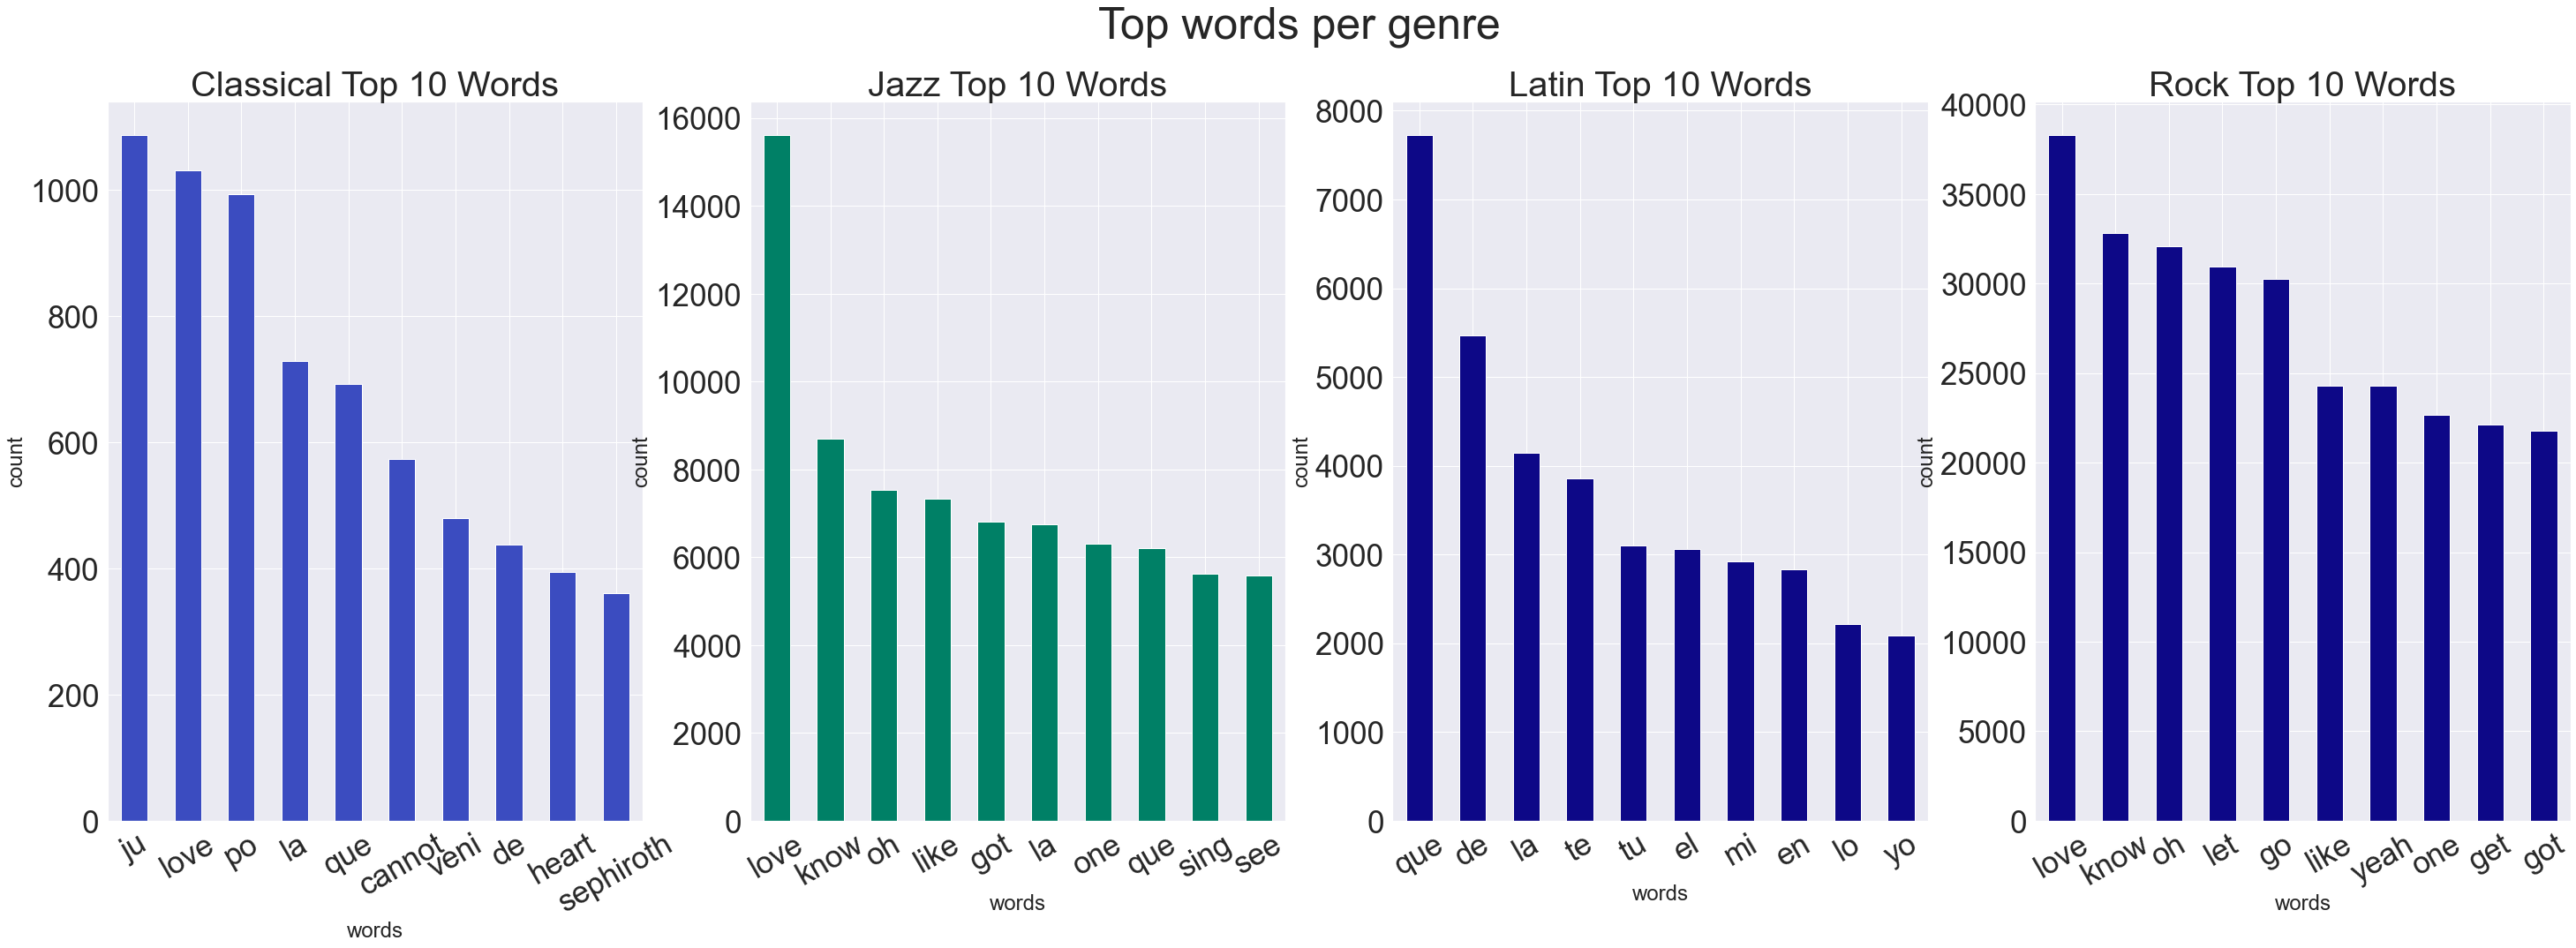

In [31]:
#Top 10 words for classical, jazz, latin and rock genres

fig, axes = plt.subplots(1, 4, figsize=(50, 15), sharey=False)
fig.suptitle('Top words per genre', size=50)
classic.head(10).plot.bar(ax=axes[0], xlabel='words', ylabel='count', cmap='coolwarm', rot=30, fontsize=35 )
axes[0].set_title('Classical Top 10 Words', size=40)

j.head(10).plot.bar(xlabel='words', ylabel='count', cmap='summer', rot=30, ax=axes[1], fontsize=35 )
axes[1].set_title('Jazz Top 10 Words', size=40)

l.head(10).plot.bar(xlabel='words', ylabel='count', cmap='plasma', rot=30, ax=axes[2], fontsize=35)
axes[2].set_title('Latin Top 10 Words', size=40)

r.head(10).plot.bar(xlabel='words', ylabel='count', cmap='plasma', rot=30, ax=axes[3], fontsize=35 )
axes[3].set_title('Rock Top 10 Words', size=40)


#sns.set(font_scale = 2)

From above, it seems as if Jazz and Rock top words are very similar.. this gives insight that our model might not score extremely high cause some songs have classification overlap. This can also be said for Classical genre and Latin. We see word overlap in the Classical plot.

In [32]:
#I want to create a variable that holds the mean popularity of each genre. This will be used to plot a chart down below.
group_by = lyrics_df.groupby('genres')['popularity'].mean().sort_values() 
group_by

genres
classical    15.985586
blues        20.222741
house        20.447818
jazz         21.614356
other        21.834671
country      31.378815
rock         35.298216
pop          36.188229
metal        45.065532
latin        45.798768
hip hop      48.476640
Name: popularity, dtype: float64

Text(0.5, 1.0, 'Popularity by Genre')

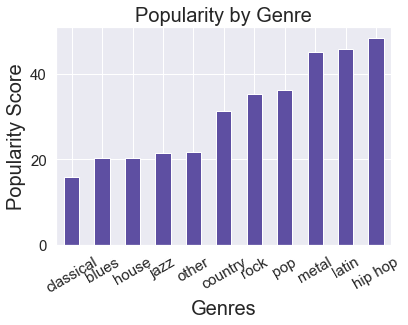

In [33]:
#Plotting the popularity among all for each genre.
group_by.plot.bar(cmap='Spectral_r', rot=30, fontsize=15)
plt.xlabel('Genres', size=20)
plt.ylabel('Popularity Score', size=20)
plt.title('Popularity by Genre', size=20)

We see that hip hop has the highest level of popularity, which coincides with our previous observation that high word count is associated with a high popularity and vice versa.

# Word Vectors

We will be using train test split for our model set up. We will also be encoding our y, and pushing our lyrics through Word2Vec here. Train test split is being done before word 2 vec as to minimize overfit.

In [10]:
#Code adapted from Dipika Baad Medium.com

#splitting dataset into train test
X = lyrics_df.drop(columns = ['genres'], axis=1)
y = lyrics_df['genres']

#encoding our y for modeling.
le = LabelEncoder()
y_le = le.fit_transform(y)


#I will be doing a train test split and setting my random seed at 42. I am doing this before Word2Vec to reduce overfitting.
X_train, X_test, y_train, y_test = train_test_split(X, y_le,
                                                   stratify=y,
                                                   test_size=0.3,
                                                   random_state=42)



print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [11]:
display(X.shape)
display(X_train.shape)
display(y_test.shape)
display(y_train.shape)

(87653, 6)

(61357, 6)

(26296,)

(61357,)

In [123]:
y_le #We see that y_le is an array, which is what we want.

array([0, 0, 0, ..., 9, 9, 9])

## Word2Vec
I will be using Word2Vec to capture the semantics and syntax of the words. I want to better understand the relationship among the words, and Word2Vec will allow me to explore these relationships more in depth.

In [46]:
#Word 2 vec is a 2 layer neural network that works to produce word embeddings for better word 
#representation. Word2vec learns vector representation through the contexts.

model = Word2Vec(sentences = lyrics_df['lyrics_cleaned'], size=200, workers=3) # I chose size 200 cause I want to generate a vector of that size.
#Set workers to 3 for my cores for training.

In [50]:
print(model) #The model generates 200-dimensional word vectors.

Word2Vec(vocab=46824, size=200, alpha=0.025)


In [48]:
model.save(r'C:\Users\Fib0nacci\Desktop\ML_genres.model') #Saving our vectors 

In [131]:
model.save("model.bin") #Saving the bin of words